In [183]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
from sklearn.cluster import DBSCAN
from sklearn.datasets import fetch_openml
import csv
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


warnings.filterwarnings('ignore')
sns.set(style="whitegrid")



In [184]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nikolasyudistira/top-50-crypto-5m-1y")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\globa\.cache\kagglehub\datasets\nikolasyudistira\top-50-crypto-5m-1y\versions\1


In [351]:
# the source for the file download is 
dfOP=pd.read_csv("C:/Users/globa/.cache/kagglehub/datasets/nikolasyudistira/top-50-crypto-5m-1y/versions/1/OPUSDT_ohlc_data.csv")
#dfLink=pd.read_csv(
#dfGrt=pd.read_csv(
dfETH=pd.read_csv("C:/Users/globa/.cache/kagglehub/datasets/nikolasyudistira/top-50-crypto-5m-1y/versions/1/ETHUSDT_ohlc_data.csv")
dfETH.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105120 entries, 0 to 105119
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   open_time           105120 non-null  object 
 1   open                105120 non-null  float64
 2   high                105120 non-null  float64
 3   low                 105120 non-null  float64
 4   close               105120 non-null  float64
 5   volume              105120 non-null  float64
 6   close_time          105120 non-null  int64  
 7   quote_asset_volume  105120 non-null  float64
 8   number_of_trades    105120 non-null  int64  
 9   taker_buy_base      105120 non-null  float64
 10  taker_buy_quote     105120 non-null  float64
 11  ignore              105120 non-null  int64  
dtypes: float64(8), int64(3), object(1)
memory usage: 9.6+ MB


In [352]:
dfETH=dfETH.drop(['high', 'low', 'close_time','volume', 'taker_buy_base', 'taker_buy_quote', 'ignore'], axis=1)
dfOP=dfOP.drop(['high', 'low', 'close_time', 'volume', 'taker_buy_base', 'taker_buy_quote', 'ignore'], axis=1)
dfOP.tail()


,open_time,open,close,quote_asset_volume,number_of_trades
105115,2024-10-19 06:35:00,1.725,1.727,9051.39853,69
105116,2024-10-19 06:40:00,1.726,1.725,9957.07281,100
105117,2024-10-19 06:45:00,1.726,1.724,13199.30545,188
105118,2024-10-19 06:50:00,1.724,1.722,12174.73726,39
105119,2024-10-19 06:55:00,1.723,1.723,13105.28267,27


In [353]:
#converting timestamp to datetime format

dfOP['open_time']=pd.to_datetime(dfOP['open_time'])
dfETH['open_time']=pd.to_datetime(dfETH['open_time'])


In [354]:
OP_seq = dfOP['open_time'].is_monotonic_increasing
Eth_seq = dfETH['open_time'].is_monotonic_increasing
print("Is Optimism dataset sequential? {}".format(OP_seq))
print('Is Ethereum dataset sequential? {}'.format(Eth_seq))

Is Optimism dataset sequential? True
Is Ethereum dataset sequential? True


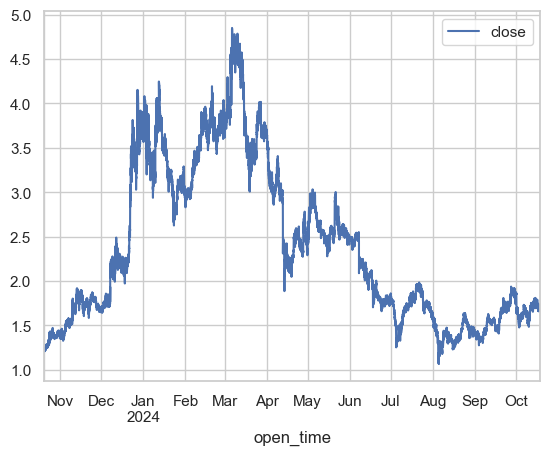

In [355]:
#Time series for Optimism token
dfOP.index=dfOP.open_time
dfOP.plot(y='close')
plt.show()

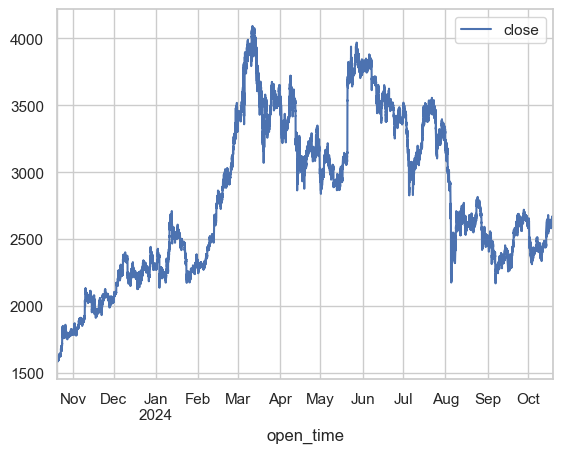

In [276]:
#Time series for Ethereum token
dfETH.index=dfETH.open_time
dfETH.plot(y='close')
plt.show()

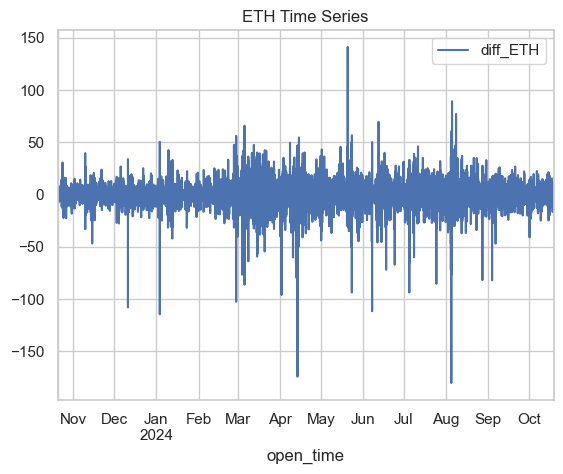

In [277]:
dfETH['diff_ETH'] = dfETH.close - dfETH.close.shift()
dfETH.plot(y='diff_ETH')
plt.title('ETH Time Series')
plt.show()


In [201]:
dfETH['diff_ETH'].mean()

0.010098554971032831

Text(0.5, 1.0, 'ETH_PACF')

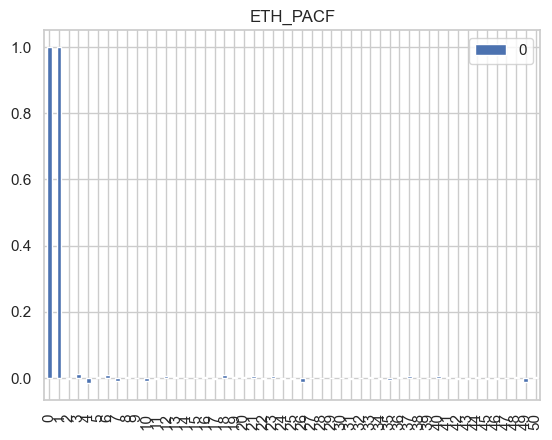

In [135]:
from statsmodels.tsa.stattools import pacf
x_acf = pd.DataFrame(pacf(dfETH.close))
x_acf.plot(kind='bar')
plt.title("ETH_PACF")


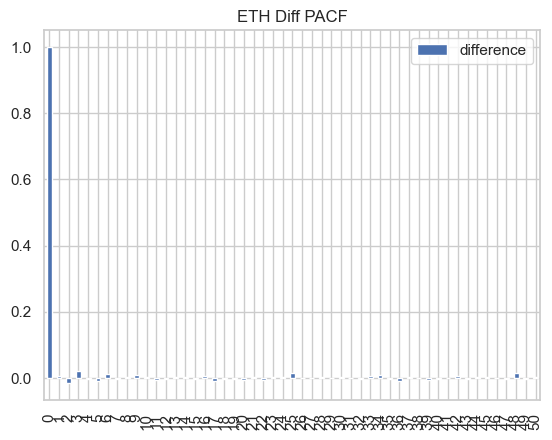

In [180]:
x_acf = pd.DataFrame(pacf(dfETH.diff_ETH[1:]))
x_acf.plot(kind='bar')
plt.title("ETH Diff PACF")
plt.legend(['difference'])


In [278]:
#storing values to separate arrays
ETH_close = dfETH['close']
ETH_values = ETH_close.values
ETH_values = ETH_values.reshape(-1,1)

In [279]:
from sklearn.preprocessing import MinMaxScaler
#SCALING THE DATA
trainingScaler = MinMaxScaler(feature_range=(0,1))
#Transform the Values
ETH_values_scaled = trainingScaler.fit_transform(ETH_values)
print(len(ETH_values_scaled))

105120


In [280]:
import math
#CREATING TRAINING and TESTING DATASETS, 85% of data used to train and 15% to test
training_split = math.floor(len(ETH_values_scaled) * 0.8) 
# "X" values in batches of 72 (72 of 5 minutes intervals = 6 hours), target variable is 73rd interval. 
# If used in the model - the prediction is made using 6 hours of previous data.
training_ETH = ETH_values_scaled[0:training_split]
training_ind_ETH = []
training_dep_ETH=[]

#Preparing Training Data
for i in range(72, len(training_ETH)):
  training_ind_ETH.append(training_ETH[i-72:i][0])
  training_dep_ETH.append(training_ETH[i][0])

training_ind_ETH, training_dep_ETH = np.array(training_ind_ETH), np.array(training_dep_ETH)
# Reshape input to be [samples, time steps, features]
training_ind_ETH = np.reshape(training_ind_ETH, (training_ind_ETH.shape[0], training_ind_ETH.shape[1], 1))


In [281]:
print(training_split)

84096


In [282]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional

#ETH model 1. LSTM - long short term memory model, used for time series forecasting. They can easily cause overfitting the data
#dropout is the regularization method to decrease overfitting


In [283]:
ETH_model = Sequential() 
ETH_model.add(LSTM(100, return_sequences=True, input_shape=(training_ind_ETH.shape[1], 1))) 
ETH_model.add(Dropout(0.2)) 
ETH_model.add(LSTM(100, return_sequences=True)) 
ETH_model.add(Dropout(0.2)) 
ETH_model.add(LSTM(100)) 
ETH_model.add(Dropout(0.2)) 
ETH_model.add(Dense(25)) 
ETH_model.add(Dense(1)) 
ETH_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 1, 100)            40800     
                                                                 
 dropout_27 (Dropout)        (None, 1, 100)            0         
                                                                 
 lstm_28 (LSTM)              (None, 1, 100)            80400     
                                                                 
 dropout_28 (Dropout)        (None, 1, 100)            0         
                                                                 
 lstm_29 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_29 (Dropout)        (None, 100)               0         
                                                                 
 dense_18 (Dense)            (None, 25)              

In [290]:
#ETH model compile, fit. 'mean squared error" meaures the variance in residuals
#Each epoch takes approx 20 seconds, it takes 4 minutes to run the model with 20 epochs. 
#In the real world 4 minutes is unacceptable when we are looking into 5 minutes intervals. 
ETH_model.compile(optimizer='adam', loss='mean_squared_error')
ETH_model.fit(training_ind_ETH, training_dep_ETH, epochs = 20, batch_size = 32, verbose=1)

Epoch 1/20
2626/2626 [==============================] - 21s 5ms/step - loss: 8.3516e-04
Epoch 2/20
2626/2626 [==============================] - 13s 5ms/step - loss: 8.1132e-04
Epoch 3/20
2626/2626 [==============================] - 13s 5ms/step - loss: 8.1396e-04
Epoch 4/20
2626/2626 [==============================] - 13s 5ms/step - loss: 8.0503e-04
Epoch 5/20
2626/2626 [==============================] - 13s 5ms/step - loss: 7.9260e-04
Epoch 6/20
2626/2626 [==============================] - 14s 5ms/step - loss: 7.8825e-04
Epoch 7/20
2626/2626 [==============================] - 14s 5ms/step - loss: 7.8786e-04
Epoch 8/20
2626/2626 [==============================] - 14s 5ms/step - loss: 7.8020e-04
Epoch 9/20
2626/2626 [==============================] - 15s 6ms/step - loss: 7.7472e-04
Epoch 10/20
2626/2626 [==============================] - 14s 6ms/step - loss: 7.6769e-04
Epoch 11/20
2626/2626 [==============================] - 15s 6ms/step - loss: 7.6948e-04
Epoch 12/20
2626/2626 [=======

In [151]:
#Each epoch takes over 20 seconds, it over 3 minutes to run the model with 10 epochs. 
#In the real world 3 minutes is unacceptable when we are looking into 5 minutes intervals. 


In [291]:
#TESTING DATASET PREPARATION
#ETH
testing_input_ETH = ETH_values[training_split:]
testing_input_ETH = trainingScaler.fit_transform(testing_input_ETH)
testing_ETH = []
for i in range(72, len(testing_input_ETH) + 72):
  testing_ETH.append(testing_input_ETH[i-72:i][0])
testing_ETH = np.array(testing_ETH)
testing_ETH = np.reshape(testing_ETH, (testing_ETH.shape[0], testing_ETH.shape[1], 1))
predict_ETH = ETH_model.predict(testing_ETH)
predict_ETH = trainingScaler.inverse_transform(predict_ETH)

657/657 [==============================] - 3s 2ms/step


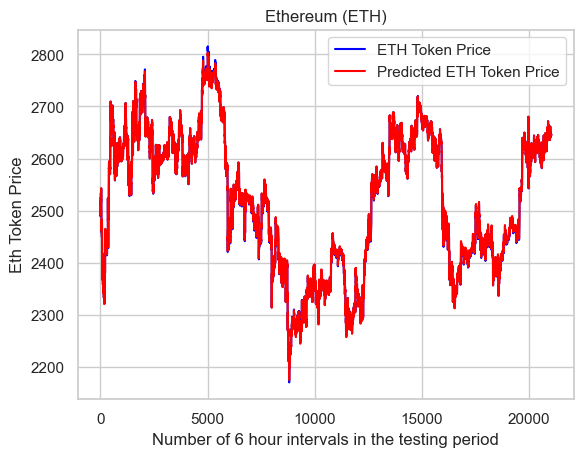

In [292]:
# Ethereum predicted/actual values plot
plt.plot(ETH_values[training_split:], color = 'blue', label = 'ETH Token Price')
plt.plot(predict_ETH, color = 'red', label = 'Predicted ETH Token Price')
plt.title('Ethereum (ETH)')
plt.xlabel('Number of 6 hour intervals in the testing period')
plt.ylabel('Eth Token Price')
plt.legend()
plt.show()

In [293]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
mape = mean_absolute_percentage_error(ETH_values[training_split:], predict_ETH)
print('MAPE:', format(mape))
mae=mean_absolute_error(ETH_values[training_split:], predict_ETH)
print('Mae:', format(mae))
m=dfETH['diff_ETH'].iloc[training_split:].mean()
print('Mean Difference in Price Movement:', format(m))

MAPE: 0.00040818279582004765
Mae: 1.0082670967183311
Mean Difference in Price Movement: 0.006884988584474886


(-30.0, 30.0)

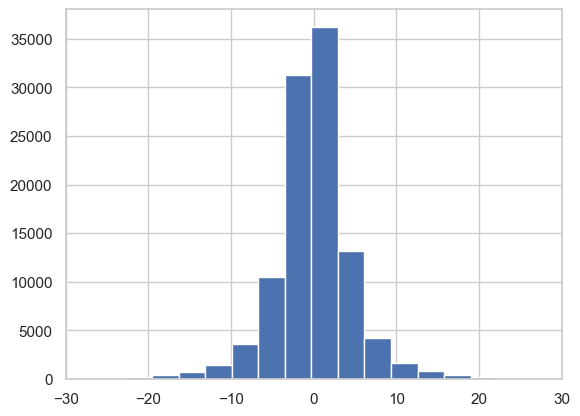

In [288]:
#dfETH['diff_ETH'].hist(bins=10)

# Create a histogram
plt.hist(dfETH['diff_ETH'], bins=100)

# Set the x-axis range
plt.xlim(-30, 30)

In [294]:
results = ETH_model.evaluate(ETH_values[training_split:], predict_ETH)
print('results')
# the loss is 6382021 which represent cumulative errors and is a very high number.

657/657 [==============================] - 3s 3ms/step - loss: 6369849.5000
results


In [ ]:
# The model seemingly produces good result with MAE of 2.7 and MAPE of 0.001 (with 10 Epochs) and Mae of 1 and Mape of 0.0004 (with 20 Epochs), 
# but if we analyse 5-minute price changes (shown on histogram) we can see that approx 90% of price changes are within +/- 10 range and approx 75% of 
# price changes are within +/- 3 range. So, mean absolute prediction error is too close to Ethereum 5-minute price variations.  
# Taking into consideration the time to run this model and the time we'll need to pull real-time data, this model becomes unuseful in real-life scenario a
# For the next model, I will change the interval to 3 hours and will base prediction based on previous 50 intervals

In [295]:
# Create a list of indices divisible by 36, which represent 3 hour intervals 
indices = [i for i in range(105120) if i % 36 == 0]
dfETH1=dfETH.iloc[indices]
dfETH1.head()

,open_time,open,close,quote_asset_volume,number_of_trades,diff_ETH
open_time,,,,,,
2023-10-20 07:00:00,2023-10-20 07:00:00,1583.42,1583.58,6.395818e+05,1491,NaN
2023-10-20 10:00:00,2023-10-20 10:00:00,1618.59,1618.20,4.883431e+06,4385,-0.40
2023-10-20 13:00:00,2023-10-20 13:00:00,1606.73,1607.44,2.072167e+06,2786,0.71
2023-10-20 16:00:00,2023-10-20 16:00:00,1605.45,1606.48,8.838804e+05,1515,1.02
2023-10-20 19:00:00,2023-10-20 19:00:00,1606.30,1607.56,6.426277e+05,1013,1.25


In [296]:
ETH1_close = dfETH1['close']
ETH1_values = ETH1_close.values
ETH1_values = ETH1_values.reshape(-1,1)

In [297]:
from sklearn.preprocessing import MinMaxScaler
#SCALING THE DATA
trainingScaler = MinMaxScaler(feature_range=(0,1))
#Transform the Values
ETH1_values_scaled = trainingScaler.fit_transform(ETH1_values)
print(len(ETH1_values_scaled))

2920


In [298]:
import math
#CREATING TRAINING and TESTING DATASETS
training_split = math.floor(len(ETH1_values_scaled) * 0.85) #1267+
#"X" values in batches of 50 ( hours)
training_ETH1 = ETH1_values_scaled[0:training_split]
training_ind_ETH1 = []
training_dep_ETH1=[]

#Preparing Training Data
for i in range(50, len(training_ETH1)):
  training_ind_ETH1.append(training_ETH1[i-50:i][0])
  training_dep_ETH1.append(training_ETH1[i][0])

training_ind_ETH1, training_dep_ETH1 = np.array(training_ind_ETH1), np.array(training_dep_ETH1)
training_ind_ETH1 = np.reshape(training_ind_ETH1, (training_ind_ETH1.shape[0], training_ind_ETH1.shape[1], 1))

In [299]:
#ETH1 model
ETH1_model = Sequential()
ETH1_model.add(LSTM(100, return_sequences=True, input_shape=(training_ind_ETH1.shape[1], 1)))
ETH1_model.add(Dropout(0.2))
ETH1_model.add(LSTM(100, return_sequences=True))
ETH1_model.add(Dropout(0.2))
ETH1_model.add(LSTM(100))
ETH1_model.add(Dropout(0.2))
ETH1_model.add(Dense(25))
ETH1_model.add(Dense(1))
ETH1_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 1, 100)            40800     
                                                                 
 dropout_30 (Dropout)        (None, 1, 100)            0         
                                                                 
 lstm_31 (LSTM)              (None, 1, 100)            80400     
                                                                 
 dropout_31 (Dropout)        (None, 1, 100)            0         
                                                                 
 lstm_32 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_32 (Dropout)        (None, 100)               0         
                                                                 
 dense_20 (Dense)            (None, 25)              

In [339]:
# Eth model 2 compile, fit
ETH1_model.compile(loss='mae', optimizer='adam', metrics=['mse', 'mae', 'accuracy', 'mape'])
ETH1_model.fit(training_ind_ETH1, training_dep_ETH1, epochs = 10, batch_size = 32, verbose=1)

Epoch 1/10
76/76 [==============================] - 7s 4ms/step - loss: 0.0733 - mse: 0.0096 - mae: 0.0733 - accuracy: 4.1118e-04 - mape: 16.9512
Epoch 2/10
76/76 [==============================] - 0s 4ms/step - loss: 0.0738 - mse: 0.0097 - mae: 0.0738 - accuracy: 4.1118e-04 - mape: 16.9528
Epoch 3/10
76/76 [==============================] - 0s 5ms/step - loss: 0.0744 - mse: 0.0099 - mae: 0.0744 - accuracy: 4.1118e-04 - mape: 16.8526
Epoch 4/10
76/76 [==============================] - 0s 5ms/step - loss: 0.0735 - mse: 0.0097 - mae: 0.0735 - accuracy: 4.1118e-04 - mape: 16.5896
Epoch 5/10
76/76 [==============================] - 0s 4ms/step - loss: 0.0746 - mse: 0.0099 - mae: 0.0746 - accuracy: 4.1118e-04 - mape: 17.0255
Epoch 6/10
76/76 [==============================] - 0s 5ms/step - loss: 0.0736 - mse: 0.0098 - mae: 0.0736 - accuracy: 4.1118e-04 - mape: 16.7607
Epoch 7/10
76/76 [==============================] - 0s 5ms/step - loss: 0.0735 - mse: 0.0097 - mae: 0.0735 - accuracy: 4.111

In [238]:
print(ETH1_values[2919])

[2648.77]


In [340]:
#TESTING DATASET PREPARATION
# ETH1
testing_input_ETH1 = ETH1_values[training_split:]
testing_input_ETH1 = trainingScaler.fit_transform(testing_input_ETH1)
testing_ETH1 = []
for i in range(50, len(testing_input_ETH1) + 50):
  testing_ETH1.append(testing_input_ETH1[i-50:i][0])
testing_ETH1 = np.array(testing_ETH1)
testing_ETH1 = np.reshape(testing_ETH1, (testing_ETH1.shape[0], testing_ETH1.shape[1], 1))
predict_ETH1 = ETH1_model.predict(testing_ETH1)
predict_ETH1 = trainingScaler.inverse_transform(predict_ETH1)

14/14 [==============================] - 2s 3ms/step


(array([  5.,  20.,  20.,  40.,  34.,  51.,  54.,  26.,  52., 136.]),
 array([806.66039242, 819.21695069, 831.77350895, 844.33006722,
        856.88662548, 869.44318375, 881.99974202, 894.55630028,
        907.11285855, 919.66941681, 932.22597508]),
 <BarContainer object of 10 artists>)

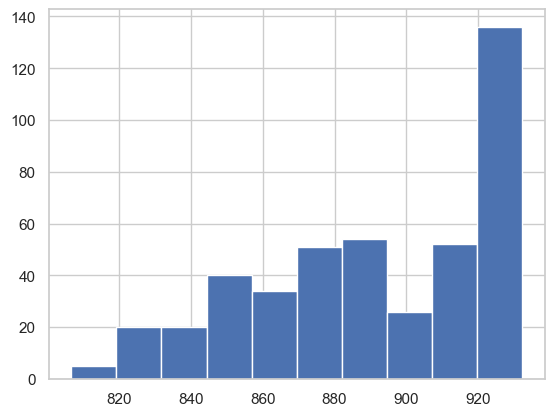

In [388]:
#plt.hist(error)
testing_input_ETH1= trainingScaler.inverse_transform(testing_input_ETH1)
error=predict_ETH1-testing_input_ETH1
plt.hist(error)


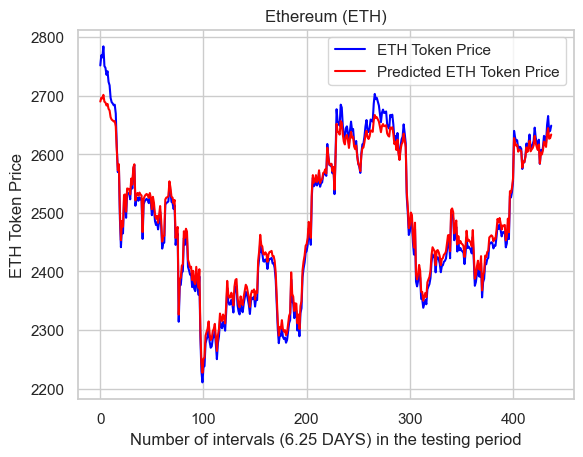

In [342]:
# Optimism
plt.plot(ETH1_values[training_split:], color = 'blue', label = 'ETH Token Price')
plt.plot(predict_ETH1, color = 'red', label = 'Predicted ETH Token Price')
plt.title('Ethereum (ETH)')
plt.xlabel('Number of 3 hour intervals in the testing period')
plt.ylabel('ETH Token Price')
plt.legend()
plt.show()

In [344]:
results = ETH1_model.evaluate(ETH1_values[training_split:], predict_ETH1)
print('results')


14/14 [==============================] - 2s 4ms/step - loss: 2488.4883 - mse: 6205408.0000 - mae: 2488.4883 - accuracy: 0.0000e+00 - mape: 99.9832
results


In [345]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
mape = mean_absolute_percentage_error(ETH1_values[training_split:], predict_ETH1)
print('MAPE:', format(mape))
mae=mean_absolute_error(ETH1_values[training_split:], predict_ETH1)
print('Mae:', format(mae))
dfETH1['diff_ETH']=dfETH1['close']-dfETH1['close'].shift()
m=dfETH1['diff_ETH'].iloc[training_split:].mean()
print('Mean Difference in Price Movement:', format(m))

MAPE: 0.004986633986859336
Mae: 12.478239757241727
Mean Difference in Price Movement: -0.2399086757990866


In [ ]:
# The model with 3 hour intervals has slightly lower loss, higher MAPE (0.007) and  MAE (17.5). Ethereum price movements are also larger in 3 hour 
# intervals. This model has much faster run time, with no significant difference between 10 and 20 number of Epochs. 
# Changing loss function to "mean absolute error" (from "mean_squared_error") results in much lower loss 6.3 mln vs 2491, lower MAPE - 0.005, Mae - 13.8. 
 

(-120.0, 120.0)

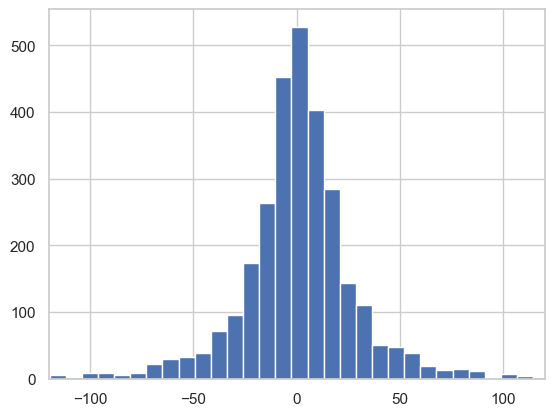

In [246]:
# Creating a histogram of price differences between two subsequent intervals
plt.hist(dfETH1['diff_ETH'], bins=100)
# Setting the x-axis range
plt.xlim(-120, 120)

In [356]:
# Creating the same model for Optimism token to see if different token is more predictable
# Create a list of indices divisible by 36, which represent 3 hour intervals 
indices = [i for i in range(105120) if i % 36 == 0]
dfOP=dfOP.iloc[indices]
dfOP.head()

,open_time,open,close,quote_asset_volume,number_of_trades
open_time,,,,,
2023-10-20 07:00:00,2023-10-20 07:00:00,1.208,1.207,10775.21338,58
2023-10-20 10:00:00,2023-10-20 10:00:00,1.243,1.242,90005.32556,235
2023-10-20 13:00:00,2023-10-20 13:00:00,1.222,1.222,23736.16375,67
2023-10-20 16:00:00,2023-10-20 16:00:00,1.226,1.229,28102.28695,82
2023-10-20 19:00:00,2023-10-20 19:00:00,1.228,1.229,51081.79745,88


In [357]:
OP_close = dfOP['close']
OP_values = OP_close.values
OP_values = OP_values.reshape(-1,1)

In [358]:
from sklearn.preprocessing import MinMaxScaler
#SCALING THE DATA
trainingScaler = MinMaxScaler(feature_range=(0,1))
#Transform the Values
OP_values_scaled = trainingScaler.fit_transform(OP_values)
print(len(OP_values_scaled))

2920


In [381]:
import math
#CREATING TRAINING and TESTING DATASETS
training_split = math.floor(len(OP_values_scaled) * 0.85) #1267+
#"X" values in batches of 4 intervals (12 hours)
training_OP = OP_values_scaled[0:training_split]
training_ind_OP = []
training_dep_OP=[]

#Preparing Training Data
for i in range(4, len(training_OP)):
  training_ind_OP.append(training_OP[i-4:i][0])
  training_dep_OP.append(training_OP[i][0])

training_ind_OP, training_dep_OP = np.array(training_ind_OP), np.array(training_dep_OP)
training_ind_OP = np.reshape(training_ind_OP, (training_ind_OP.shape[0], training_ind_OP.shape[1], 1))

In [382]:
# OP model
OP_model = Sequential()
OP_model.add(LSTM(100, return_sequences=True, input_shape=(training_ind_OP.shape[1], 1)))
OP_model.add(Dropout(0.2))
OP_model.add(LSTM(100, return_sequences=True))
OP_model.add(Dropout(0.2))
OP_model.add(LSTM(100))
OP_model.add(Dropout(0.2))
OP_model.add(Dense(25))
OP_model.add(Dense(1))
OP_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 1, 100)            40800     
                                                                 
 dropout_48 (Dropout)        (None, 1, 100)            0         
                                                                 
 lstm_49 (LSTM)              (None, 1, 100)            80400     
                                                                 
 dropout_49 (Dropout)        (None, 1, 100)            0         
                                                                 
 lstm_50 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_50 (Dropout)        (None, 100)               0         
                                                                 
 dense_32 (Dense)            (None, 25)              

In [384]:
# OP model compile, fit
OP_model.compile(optimizer='adam',loss='mse', metrics=['mse', 'mae', 'accuracy', 'mape'])
OP_model.fit(training_ind_OP, training_dep_OP, epochs = 10, batch_size = 32, verbose=1)

Epoch 1/10
78/78 [==============================] - 8s 5ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0286 - accuracy: 8.0710e-04 - mape: 15945.7744
Epoch 2/10
78/78 [==============================] - 0s 5ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0284 - accuracy: 8.0710e-04 - mape: 7152.3174
Epoch 3/10
78/78 [==============================] - 0s 5ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0281 - accuracy: 8.0710e-04 - mape: 22145.2090
Epoch 4/10
78/78 [==============================] - 0s 6ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0286 - accuracy: 8.0710e-04 - mape: 8302.7363
Epoch 5/10
78/78 [==============================] - 0s 5ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0276 - accuracy: 8.0710e-04 - mape: 32296.2930
Epoch 6/10
78/78 [==============================] - 0s 5ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0278 - accuracy: 8.0710e-04 - mape: 19298.6582
Epoch 7/10
78/78 [==============================] - 0s 6ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0279 -

In [385]:
#TESTING DATASET PREPARATION
# OP
testing_input_OP = OP_values[training_split:]
testing_input_OP = trainingScaler.fit_transform(testing_input_OP)
testing_OP = []
for i in range(4, len(testing_input_OP) + 4):
  testing_OP.append(testing_input_OP[i-4:i][0])
testing_OP = np.array(testing_OP)
testing_OP = np.reshape(testing_OP, (testing_OP.shape[0], testing_OP.shape[1], 1))
predict_OP = OP_model.predict(testing_OP)
predict_OP = trainingScaler.inverse_transform(predict_OP)

14/14 [==============================] - 2s 3ms/step


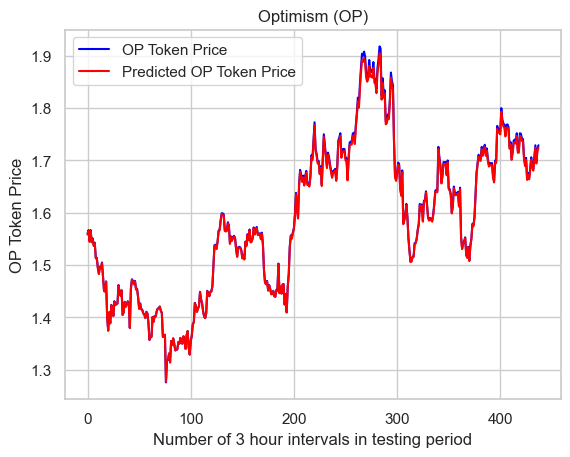

In [386]:
# Optimism
plt.plot(OP_values[training_split:], color = 'blue', label = 'OP Token Price')
plt.plot(predict_OP, color = 'red', label = 'Predicted OP Token Price')
plt.title('Optimism (OP)')
plt.xlabel('Number of 3 hour intervals in testing period')
plt.ylabel('OP Token Price')
plt.legend()
plt.show()

In [387]:
results = OP_model.evaluate(OP_values[training_split:], predict_OP)
print('results')


14/14 [==============================] - 2s 3ms/step - loss: 0.0097 - mse: 0.0097 - mae: 0.0948 - accuracy: 0.0000e+00 - mape: 5.8752
results


<Axes: >

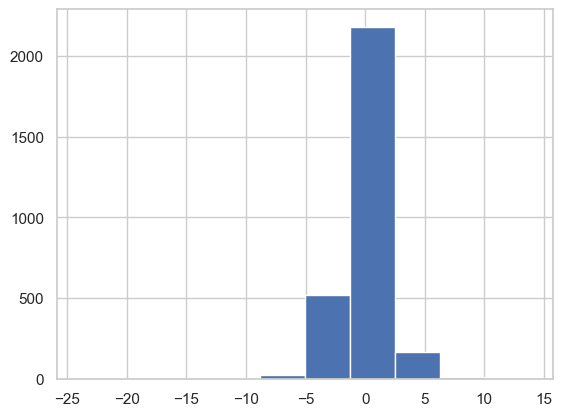

In [365]:
dfOP['%']=(dfOP['close']-dfOP['close'].shift())/dfOP['close']*100
dfOP['%'].hist()

In [ ]:
# If we look at the histogram of % price difference from previous interval: majority of values are within +/- 5% 
# Models (prediction based on 50 prior intervals) MAPE of over 20 % indicates that the mean difference between predicted value and true value is 20%,
# that exceeds token price fluctiations and can't be used as an effective model. 
# To summarize: model is more accurate if it's based on less prior data (4 prior intervals- 12 hours resulted in better prediction than 50 intervals - 6.25 days)
# 4 interval prediction returned MAPE of 2.8% while 50 intervals had a MAPE of over 20%
# Loss function 'MAE' performed slightly better than 'MSE'
# Rerunning the same model (different smaples of data) returns inconsistent results. 